
Bu notebook, kredi karti dolandiricilik tespiti icin iki gelismis makine ogrenimi modeli uygular:
1. **Random Forest** (Topluluk Yontemi)
2. **XGBoost** (Gradient Boosting)

Her iki model de hiperparametre ayari ve kapsamli degerlendirme metrikleri icerir.

## 1. Kutuphanelerin Yuklenmesi

In [5]:
# Gerekli kutuphaneleri ice aktar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

print("Kutuphaneler basariyla yuklendi!")

Kutuphaneler basariyla yuklendi!


## 2. Temizlenmis Verilerin Yuklenmesi
`data/processed/creditcard_clean.csv` dosyasindan onceden islenmis veriler yukleniyor

In [6]:
# Temizlenmis veri setini yukle
df = pd.read_csv('data/processed/creditcard_clean.csv')

print(f"Veri Seti Boyutu: {df.shape}")
print(f"\nSinif Dagilimi:")
print(df['Class'].value_counts())
print(f"\nDolandiricilik Orani: %{df['Class'].mean() * 100:.2f}")
df.head()

Veri Seti Boyutu: (283726, 33)

Sinif Dagilimi:
Class
0    283253
1       473
Name: count, dtype: int64

Dolandiricilik Orani: %0.17


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled,Time_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244200,-1.996823
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342584,-1.996823
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.158900,-1.996802
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.139886,-1.996802
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073813,-1.996781


## 3. Egitim Icin Verilerin Hazirlanmasi

In [7]:
# Ozellikler ve hedef degiskeni ayir
X = df.drop('Class', axis=1)
y = df['Class']

# Verileri egitim ve test setlerine bol
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Egitim seti boyutu: {X_train.shape[0]}")
print(f"Test seti boyutu: {X_test.shape[0]}")
print(f"\nEgitim seti sinif dagilimi:")
print(y_train.value_counts())

Egitim seti boyutu: 226980
Test seti boyutu: 56746

Egitim seti sinif dagilimi:
Class
0    226602
1       378
Name: count, dtype: int64


## 4. Model 1: Hiperparametre Ayarli Random Forest

In [8]:
# Random Forest parametre izgarasini tanimla
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest modelini baslat
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Daha hizli ayarlama icin RandomizedSearchCV uygula
rf_search = RandomizedSearchCV(
    rf_model, 
    rf_param_grid, 
    n_iter=20,
    cv=3, 
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Random Forest Hiperparametre Ayari ile Egitiliyor...")
rf_search.fit(X_train, y_train)

print(f"\nEn Iyi Parametreler: {rf_search.best_params_}")
print(f"En Iyi CV F1 Skoru: {rf_search.best_score_:.4f}")

Random Forest Hiperparametre Ayari ile Egitiliyor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

En Iyi Parametreler: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
En Iyi CV F1 Skoru: 0.8553


In [9]:
# En iyi Random Forest modelini al
best_rf = rf_search.best_estimator_

# Tahminleri yap
rf_pred = best_rf.predict(X_test)
rf_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Metrikleri hesapla
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print("=" * 50)
print("RANDOM FOREST SONUCLARI")
print("=" * 50)
print(f"Dogruluk (Accuracy):  {rf_accuracy:.4f}")
print(f"Kesinlik (Precision): {rf_precision:.4f}")
print(f"Duyarlilik (Recall):  {rf_recall:.4f}")
print(f"F1-Skoru:             {rf_f1:.4f}")
print(f"AUC:                  {rf_auc:.4f}")
print("\nSiniflandirma Raporu:")
print(classification_report(y_test, rf_pred, target_names=['Normal', 'Dolandiricilik']))

RANDOM FOREST SONUCLARI
Dogruluk (Accuracy):  0.9995
Kesinlik (Precision): 0.9722
Duyarlilik (Recall):  0.7368
F1-Skoru:             0.8383
AUC:                  0.9437

Siniflandirma Raporu:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00     56651
Dolandiricilik       0.97      0.74      0.84        95

      accuracy                           1.00     56746
     macro avg       0.99      0.87      0.92     56746
  weighted avg       1.00      1.00      1.00     56746



## 5. Model 2: Hiperparametre Ayarli XGBoost

In [10]:
# Dengesiz veriler icin scale_pos_weight hesapla
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# XGBoost parametre izgarasini tanimla
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# XGBoost modelini baslat
xgb_model = XGBClassifier(
    random_state=42, 
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

# RandomizedSearchCV uygula
xgb_search = RandomizedSearchCV(
    xgb_model, 
    xgb_param_grid, 
    n_iter=20,
    cv=3, 
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("XGBoost Hiperparametre Ayari ile Egitiliyor...")
xgb_search.fit(X_train, y_train)

print(f"\nEn Iyi Parametreler: {xgb_search.best_params_}")
print(f"En Iyi CV F1 Skoru: {xgb_search.best_score_:.4f}")

XGBoost Hiperparametre Ayari ile Egitiliyor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

En Iyi Parametreler: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
En Iyi CV F1 Skoru: 0.8612


In [11]:
# En iyi XGBoost modelini al
best_xgb = xgb_search.best_estimator_

# Tahminleri yap
xgb_pred = best_xgb.predict(X_test)
xgb_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Metrikleri hesapla
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

print("=" * 50)
print("XGBOOST SONUCLARI")
print("=" * 50)
print(f"Dogruluk (Accuracy):  {xgb_accuracy:.4f}")
print(f"Kesinlik (Precision): {xgb_precision:.4f}")
print(f"Duyarlilik (Recall):  {xgb_recall:.4f}")
print(f"F1-Skoru:             {xgb_f1:.4f}")
print(f"AUC:                  {xgb_auc:.4f}")
print("\nSiniflandirma Raporu:")
print(classification_report(y_test, xgb_pred, target_names=['Normal', 'Dolandiricilik']))

XGBOOST SONUCLARI
Dogruluk (Accuracy):  0.9995
Kesinlik (Precision): 0.9359
Duyarlilik (Recall):  0.7684
F1-Skoru:             0.8439
AUC:                  0.9797

Siniflandirma Raporu:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00     56651
Dolandiricilik       0.94      0.77      0.84        95

      accuracy                           1.00     56746
     macro avg       0.97      0.88      0.92     56746
  weighted avg       1.00      1.00      1.00     56746



## 6. ROC Egrileri Karsilastirmasi

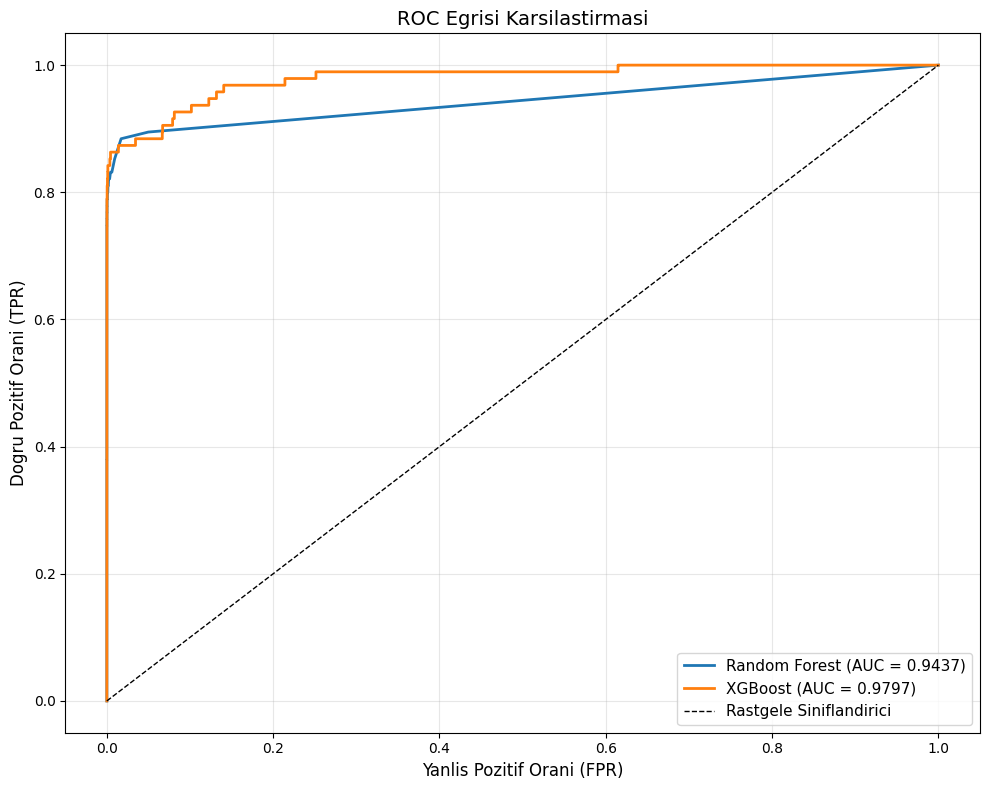

ROC Egrisi 'roc_curves.png' olarak kaydedildi


In [12]:
# ROC egrilerini hesapla
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_pred_proba)

# ROC egrilerini ciz
plt.figure(figsize=(10, 8))

plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})', linewidth=2)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Siniflandirici', linewidth=1)

plt.xlabel('Yanlis Pozitif Orani (FPR)', fontsize=12)
plt.ylabel('Dogru Pozitif Orani (TPR)', fontsize=12)
plt.title('ROC Egrisi Karsilastirmasi', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC Egrisi 'roc_curves.png' olarak kaydedildi")

## 7. Karisiklik Matrisleri

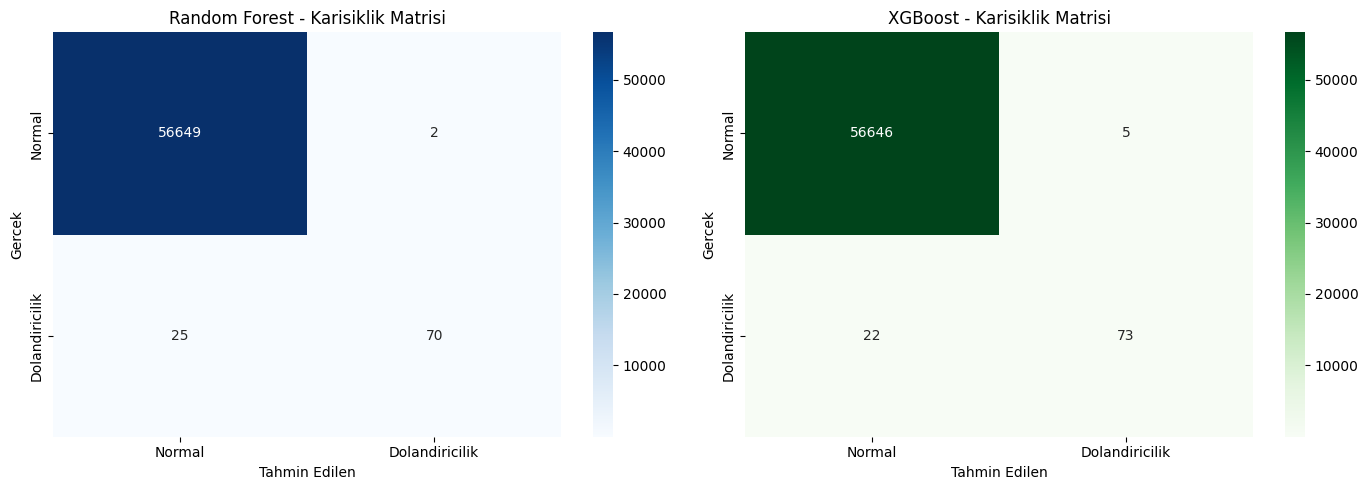

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest Karisiklik Matrisi
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Dolandiricilik'],
            yticklabels=['Normal', 'Dolandiricilik'])
axes[0].set_title('Random Forest - Karisiklik Matrisi', fontsize=12)
axes[0].set_xlabel('Tahmin Edilen')
axes[0].set_ylabel('Gercek')

# XGBoost Karisiklik Matrisi
xgb_cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Normal', 'Dolandiricilik'],
            yticklabels=['Normal', 'Dolandiricilik'])
axes[1].set_title('XGBoost - Karisiklik Matrisi', fontsize=12)
axes[1].set_xlabel('Tahmin Edilen')
axes[1].set_ylabel('Gercek')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Sonuc Karsilastirma Tablosu

In [14]:
# Sonuc DataFrame olustur
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Dogruluk': [rf_accuracy, xgb_accuracy],
    'Kesinlik': [rf_precision, xgb_precision],
    'Duyarlilik': [rf_recall, xgb_recall],
    'F1-Skoru': [rf_f1, xgb_f1],
    'AUC': [rf_auc, xgb_auc]
})

# Degerleri yuvarla
results_df = results_df.round(4)

# Sonuclari goster
print("=" * 70)
print("MODEL KARSILASTIRMA SONUCLARI")
print("=" * 70)
print(results_df.to_string(index=False))

# Sonuclari CSV dosyasina kaydet
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nSonuclar 'model_comparison_results.csv' dosyasina kaydedildi")

MODEL KARSILASTIRMA SONUCLARI
        Model  Dogruluk  Kesinlik  Duyarlilik  F1-Skoru    AUC
Random Forest    0.9995    0.9722      0.7368    0.8383 0.9437
      XGBoost    0.9995    0.9359      0.7684    0.8439 0.9797

Sonuclar 'model_comparison_results.csv' dosyasina kaydedildi


## 9. En Iyi Model Analizi

In [15]:
# F1-Skoruna gore en iyi modeli belirle (dengesiz veriler icin onemli)
best_model_idx = results_df['F1-Skoru'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print("=" * 70)
print("SON ANALIZ")
print("=" * 70)
print(f"\nEN IYI MODEL: {best_model_name}")
print(f"\nEn Iyi Model Metrikleri:")
print(results_df.loc[best_model_idx].to_string())

print("\n" + "-" * 70)
print("ANALIZ NOTLARI:")
print("-" * 70)
print("""
1. Veri Seti Ozellikleri:
   - Bu oldukca dengesiz bir veri setidir (dolandiricilik vakalari nadir)
   - F1-Skoru ve AUC, Dogruluktan daha guvenilir metriklerdir

2. Model Performansi:
   - Her iki model de sinif dengesizligini farkli mekanizmalarla ele alir
   - Random Forest topluluk oylamasi kullanir
   - XGBoost scale_pos_weight parametresini kullanir

3. Asiri Ogrenme/Yetersiz Ogrenme:
   - Hiperparametre ayari asiri ogrenmeyi onlemeye yardimci olur
   - Capraz dogrulama model genellemesini saglar
   - max_depth parametresi model karmasikligini kontrol eder

4. Oneriler:
   - Dolandiricilik tespiti icin daha fazla dolandiricilik yakalamak adina Duyarliliga oncelik verin
   - Is ihtiyaclarina gore Kesinlik ve Duyarlilik arasinda denge kurun
   - Uretim icin her iki modelin toplulugunu dusunun
""")

SON ANALIZ

EN IYI MODEL: XGBoost

En Iyi Model Metrikleri:
Model         XGBoost
Dogruluk       0.9995
Kesinlik       0.9359
Duyarlilik     0.7684
F1-Skoru       0.8439
AUC            0.9797

----------------------------------------------------------------------
ANALIZ NOTLARI:
----------------------------------------------------------------------

1. Veri Seti Ozellikleri:
   - Bu oldukca dengesiz bir veri setidir (dolandiricilik vakalari nadir)
   - F1-Skoru ve AUC, Dogruluktan daha guvenilir metriklerdir

2. Model Performansi:
   - Her iki model de sinif dengesizligini farkli mekanizmalarla ele alir
   - Random Forest topluluk oylamasi kullanir
   - XGBoost scale_pos_weight parametresini kullanir

3. Asiri Ogrenme/Yetersiz Ogrenme:
   - Hiperparametre ayari asiri ogrenmeyi onlemeye yardimci olur
   - Capraz dogrulama model genellemesini saglar
   - max_depth parametresi model karmasikligini kontrol eder

4. Oneriler:
   - Dolandiricilik tespiti icin daha fazla dolandiricilik yakala

## 10. Ozellik Onemi

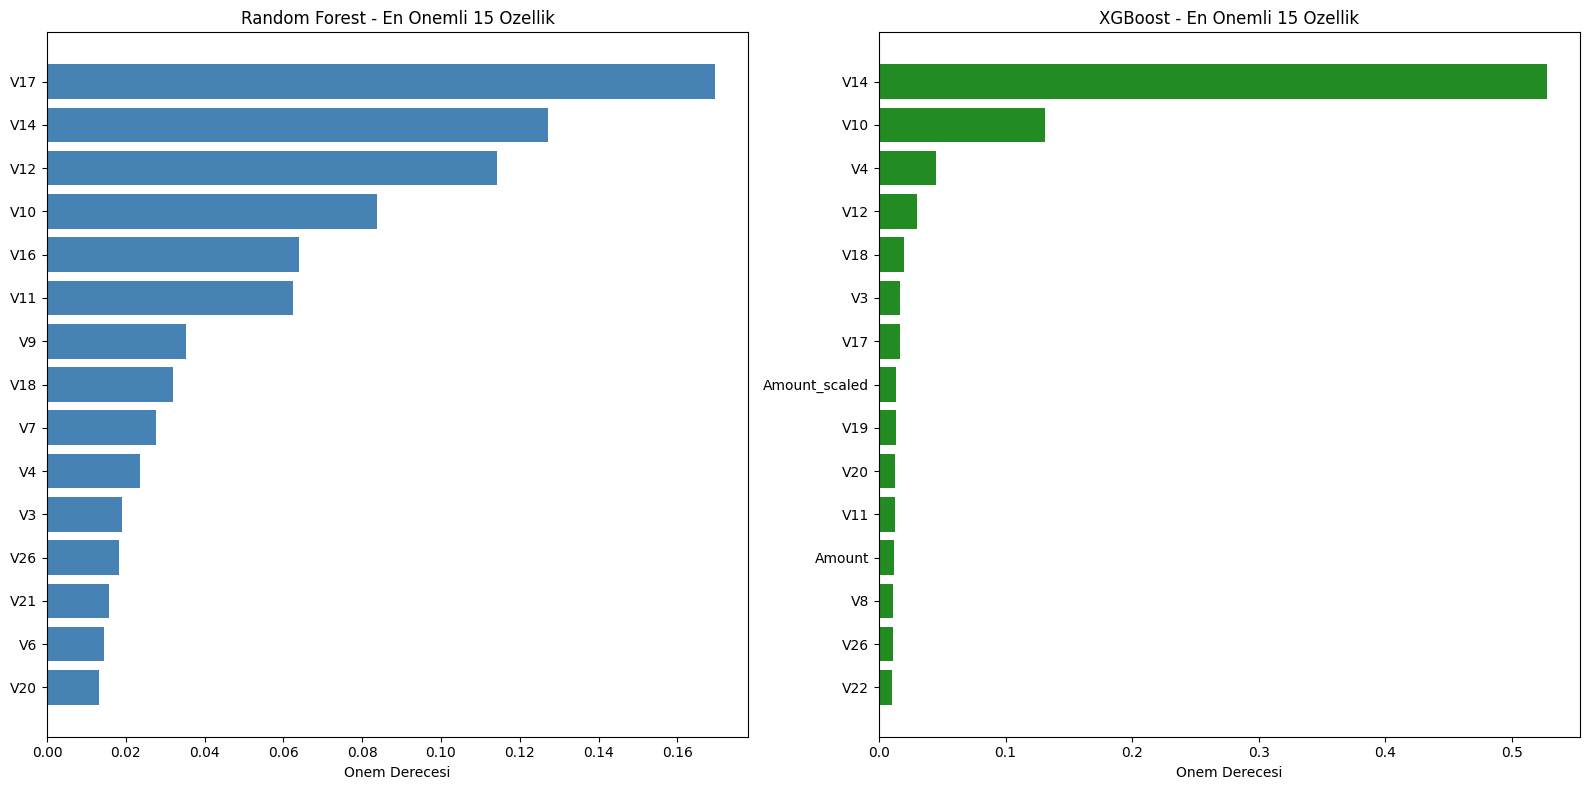

In [16]:
# En iyi modellerden ozellik onemini al
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest Ozellik Onemi
rf_importance = pd.DataFrame({
    'Ozellik': X.columns,
    'Onem': best_rf.feature_importances_
}).sort_values('Onem', ascending=True).tail(15)

axes[0].barh(rf_importance['Ozellik'], rf_importance['Onem'], color='steelblue')
axes[0].set_title('Random Forest - En Onemli 15 Ozellik', fontsize=12)
axes[0].set_xlabel('Onem Derecesi')

# XGBoost Ozellik Onemi
xgb_importance = pd.DataFrame({
    'Ozellik': X.columns,
    'Onem': best_xgb.feature_importances_
}).sort_values('Onem', ascending=True).tail(15)

axes[1].barh(xgb_importance['Ozellik'], xgb_importance['Onem'], color='forestgreen')
axes[1].set_title('XGBoost - En Onemli 15 Ozellik', fontsize=12)
axes[1].set_xlabel('Onem Derecesi')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Ozet

Bu notebook sunlari uyguladi:
1. Hiperparametre Ayarli Random Forest (n_estimators, max_depth, min_samples_split)
2. Hiperparametre Ayarli XGBoost (learning_rate, n_estimators, max_depth, subsample)
3. Tam degerlendirme metrikleri (Dogruluk, Kesinlik, Duyarlilik, F1-Skoru, AUC)
4. Her iki model icin ROC Egrileri
5. Tum metriklerle karsilastirma tablosu
6. En iyi model analizi ve dengesiz veri isleme

**Veri Kaynagi:** `data/processed/creditcard_clean.csv` (Data_Cleaning.ipynb dosyasinda on islenmis)